In [34]:
%pip install protobuf==5.28.3

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [36]:
df = pd.read_csv('../Dataset/FeatureEngineering_T2M_data.csv')
df = df.sort_values("date")

In [37]:
feature_cols = [
    # Soil Temperature
    "tsoil1", "tsoil2", "tsoil3", "tsoil4",

    # Surface / Air Temperature
    "t2m", "t2m_max", "t2m_min",
    "t10m", "t10m_max", "t10m_min",
    "ts", "ts_min", "ts_max", "tsurf",
    "t2m_range", "t10m_range", "ts_range",

    # Wind
    "v2m", "v10m", "v50m",

    # Humidity / Density
    "rhoa", "t2mwet",

    # Soil Moisture
    "gwettop", "gwetroot", "gwetprof",

    # Evapotranspiration
    "evptrns", "et_total", "evland",

    # Physical
    "z0m", "to3",
]

In [38]:
H = 7

targets = [f"t2m_d{h}_forecast" for h in range(1, H+1)]
df_clean = df[feature_cols + targets].dropna().reset_index(drop=True)

In [39]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

scaled_X = scaler_X.fit_transform(df_clean[feature_cols])
scaled_y = scaler_y.fit_transform(df_clean[targets])

In [40]:
n_features = scaled_X.shape[1]
n_features

30

In [41]:
lookback = 7

def create_sequences(X, y, lookback):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback - H):
        X_seq.append(X[i:i+lookback])   # (14, n_features)
        y_seq.append(y[i+lookback])     # (7,)
    return np.array(X_seq), np.array(y_seq)

X_seq, Y_seq = create_sequences(scaled_X, scaled_y, lookback)

X_train, X_test, Y_train, Y_test = train_test_split(
    X_seq, Y_seq, test_size=0.2, shuffle=False
)

print("X_train shape:", X_train.shape)  # (N, 14, n_features)
print("Y_train shape:", Y_train.shape)  # (N, 7)

X_train shape: (13080, 7, 30)
Y_train shape: (13080, 7)


In [42]:
model = Sequential([
    Bidirectional(
        LSTM(
            128,
            return_sequences=True,
            activation="tanh",
            input_shape=(lookback, n_features)   
        )
    ),
    Dropout(0.2),

    Bidirectional(LSTM(64, return_sequences=False, activation="tanh")),
    Dropout(0.2),

    BatchNormalization(),

    Dense(128, activation='relu'),
    Dropout(0.2),

    Dense(64, activation='relu'),
    Dense(7)     # output 7 day forecasts
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='mse'
)

c:\Users\09350\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=1e-6),
]

history = model.fit(
    X_train, Y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/200
368/368 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - loss: 0.0663 - val_loss: 0.2041 - learning_rate: 5.0000e-04
Epoch 2/200
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0161 - val_loss: 0.0176 - learning_rate: 5.0000e-04
Epoch 3/200
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0098 - val_loss: 0.0084 - learning_rate: 5.0000e-04
Epoch 4/200
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0073 - val_loss: 0.0064 - learning_rate: 5.0000e-04
Epoch 5/200
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0060 - val_loss: 0.0050 - learning_rate: 5.0000e-04
Epoch 6/200
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0054 - val_loss: 0.0050 - learning_rate: 5.0000e-04
Epoch 7/200
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0050 - val_loss: 0.0049 - learning_rate: 5.0000e-04
Epoch 8/200
368/368 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0047 - val_loss: 0.0053 - learning_rate: 5.0000e-04
Epoch 9/200
368/368 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0046 - v

In [44]:
Y_pred = model.predict(X_test)

# inverse scale
Y_test_inv = scaler_y.inverse_transform(Y_test)
Y_pred_inv = scaler_y.inverse_transform(Y_pred)

103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

H = 7

rmse_list = []
mae_list = []
mape_list = []
r2_list = []

for h in range(H):
    y_true_h = Y_test[:, h]
    y_pred_h = Y_pred[:, h]

    rmse_list.append(np.sqrt(mean_squared_error(y_true_h, y_pred_h)))
    mae_list.append(mean_absolute_error(y_true_h, y_pred_h))
    mape_list.append(mape(y_true_h, y_pred_h))
    r2_list.append(r2_score(y_true_h, y_pred_h))

# ---- Horizontal Display ----
print("==== RMSE ====")
print(" | ".join([f"Day +{i+1}: {rmse_list[i]:.3f}" for i in range(H)]))

print("\n==== MAE ====")
print(" | ".join([f"Day +{i+1}: {mae_list[i]:.3f}" for i in range(H)]))

print("\n==== MAPE (%) ====")
print(" | ".join([f"Day +{i+1}: {mape_list[i]:.2f}%" for i in range(H)]))

print("\n==== R² ====")
print(" | ".join([f"Day +{i+1}: {r2_list[i]:.3f}" for i in range(H)]))

# ---- Accuracy (%) from R² ----
print("\n==== Accuracy (%) from R² ====")
print(" | ".join([f"Day +{i+1}: {r2_list[i]*100:.1f}%" for i in range(H)]))

# ---- Overall metrics ----
rmse_overall = np.sqrt(mean_squared_error(Y_test, Y_pred))
mae_overall = mean_absolute_error(Y_test, Y_pred)
mape_overall = mape(Y_test, Y_pred)
r2_overall = r2_score(Y_test, Y_pred)

print("\n==== Overall ====")
print(f"RMSE={rmse_overall:.3f} | MAE={mae_overall:.3f} | "
      f"MAPE={mape_overall:.2f}% | R²={r2_overall:.3f} | "
      f"Accuracy={(r2_overall*100):.1f}%")

==== RMSE ====
Day +1: 0.054 | Day +2: 0.060 | Day +3: 0.063 | Day +4: 0.065 | Day +5: 0.066 | Day +6: 0.067 | Day +7: 0.067

==== MAE ====
Day +1: 0.039 | Day +2: 0.044 | Day +3: 0.046 | Day +4: 0.048 | Day +5: 0.049 | Day +6: 0.051 | Day +7: 0.050

==== MAPE (%) ====
Day +1: 6.60% | Day +2: 7.43% | Day +3: 7.82% | Day +4: 8.11% | Day +5: 8.18% | Day +6: 8.44% | Day +7: 8.40%

==== R² ====
Day +1: 0.729 | Day +2: 0.662 | Day +3: 0.630 | Day +4: 0.607 | Day +5: 0.597 | Day +6: 0.576 | Day +7: 0.578

==== Accuracy (%) from R² ====
Day +1: 72.9% | Day +2: 66.2% | Day +3: 63.0% | Day +4: 60.7% | Day +5: 59.7% | Day +6: 57.6% | Day +7: 57.8%

==== Overall ====
RMSE=0.063 | MAE=0.047 | MAPE=7.85% | R²=0.626 | Accuracy=62.6%


In [46]:
# Ensure date is datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# --- Load the last window for prediction ---
last_window = scaled_X[-lookback:]  # shape: (lookback, num_features)

# reshape → (1, lookback, num_features)
X_input = last_window.reshape(1, lookback, len(feature_cols))

# Predict next 7 days (scaled)
y_pred_scaled = model.predict(X_input)[0]   # shape: (7,)

# แปลงผลทำนายกลับเป็นองศาเซลเซียส (inverse transform)
y_pred_celsius = scaler_y.inverse_transform(y_pred_scaled.reshape(1, -1))[0]  # shape: (7,)

last_date = df["date"].iloc[-1]
forecast_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 8)]

print("Forecast Next 7 Days (Celsius):")
for d, val in zip(forecast_dates, y_pred_celsius):
    print(f"{d.strftime('%Y-%m-%d')} → {val:.2f} °C")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Forecast Next 7 Days (Celsius):
2025-11-11 → 28.43 °C
2025-11-12 → 28.15 °C
2025-11-13 → 27.80 °C
2025-11-14 → 27.79 °C
2025-11-15 → 27.54 °C
2025-11-16 → 27.39 °C
2025-11-17 → 27.32 °C


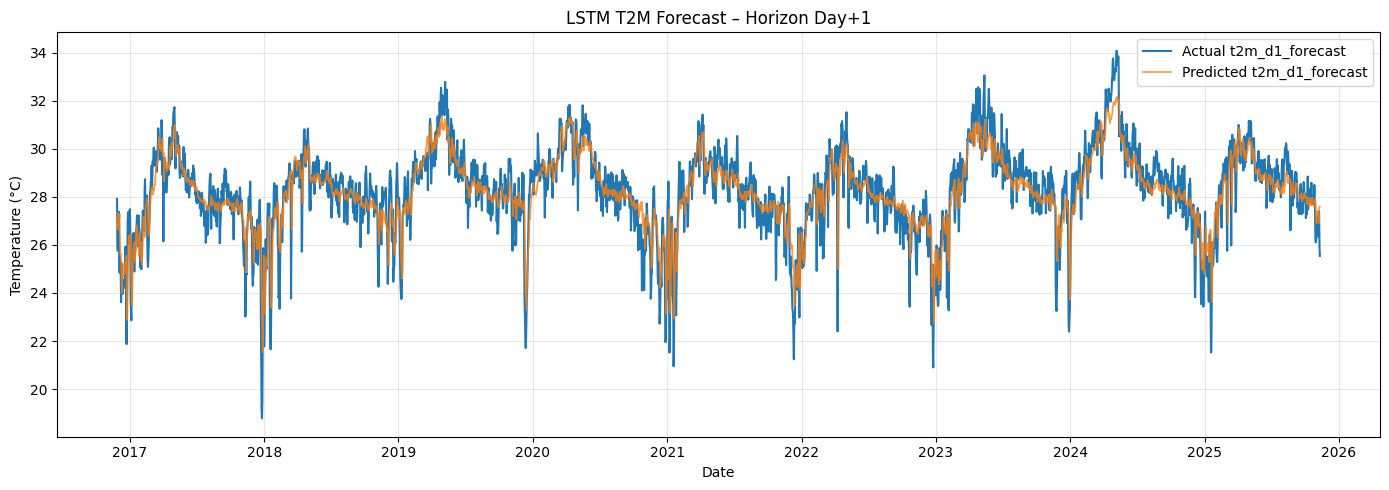

In [47]:
dates_test = pd.to_datetime(df["date"].iloc[-len(X_test):])

# เลือก horizon ที่อยากดู เช่น day+7 = index 6
h = 0   # 0 = day+1, 6 = day+7
target_name = targets[h]

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(dates_test, Y_test_inv[:, h], label=f"Actual {target_name}", linewidth=1.5)
plt.plot(dates_test, Y_pred_inv[:, h], label=f"Predicted {target_name}", linewidth=1.2, alpha=0.8)

plt.title(f"LSTM T2M Forecast – Horizon Day+{h+1}")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

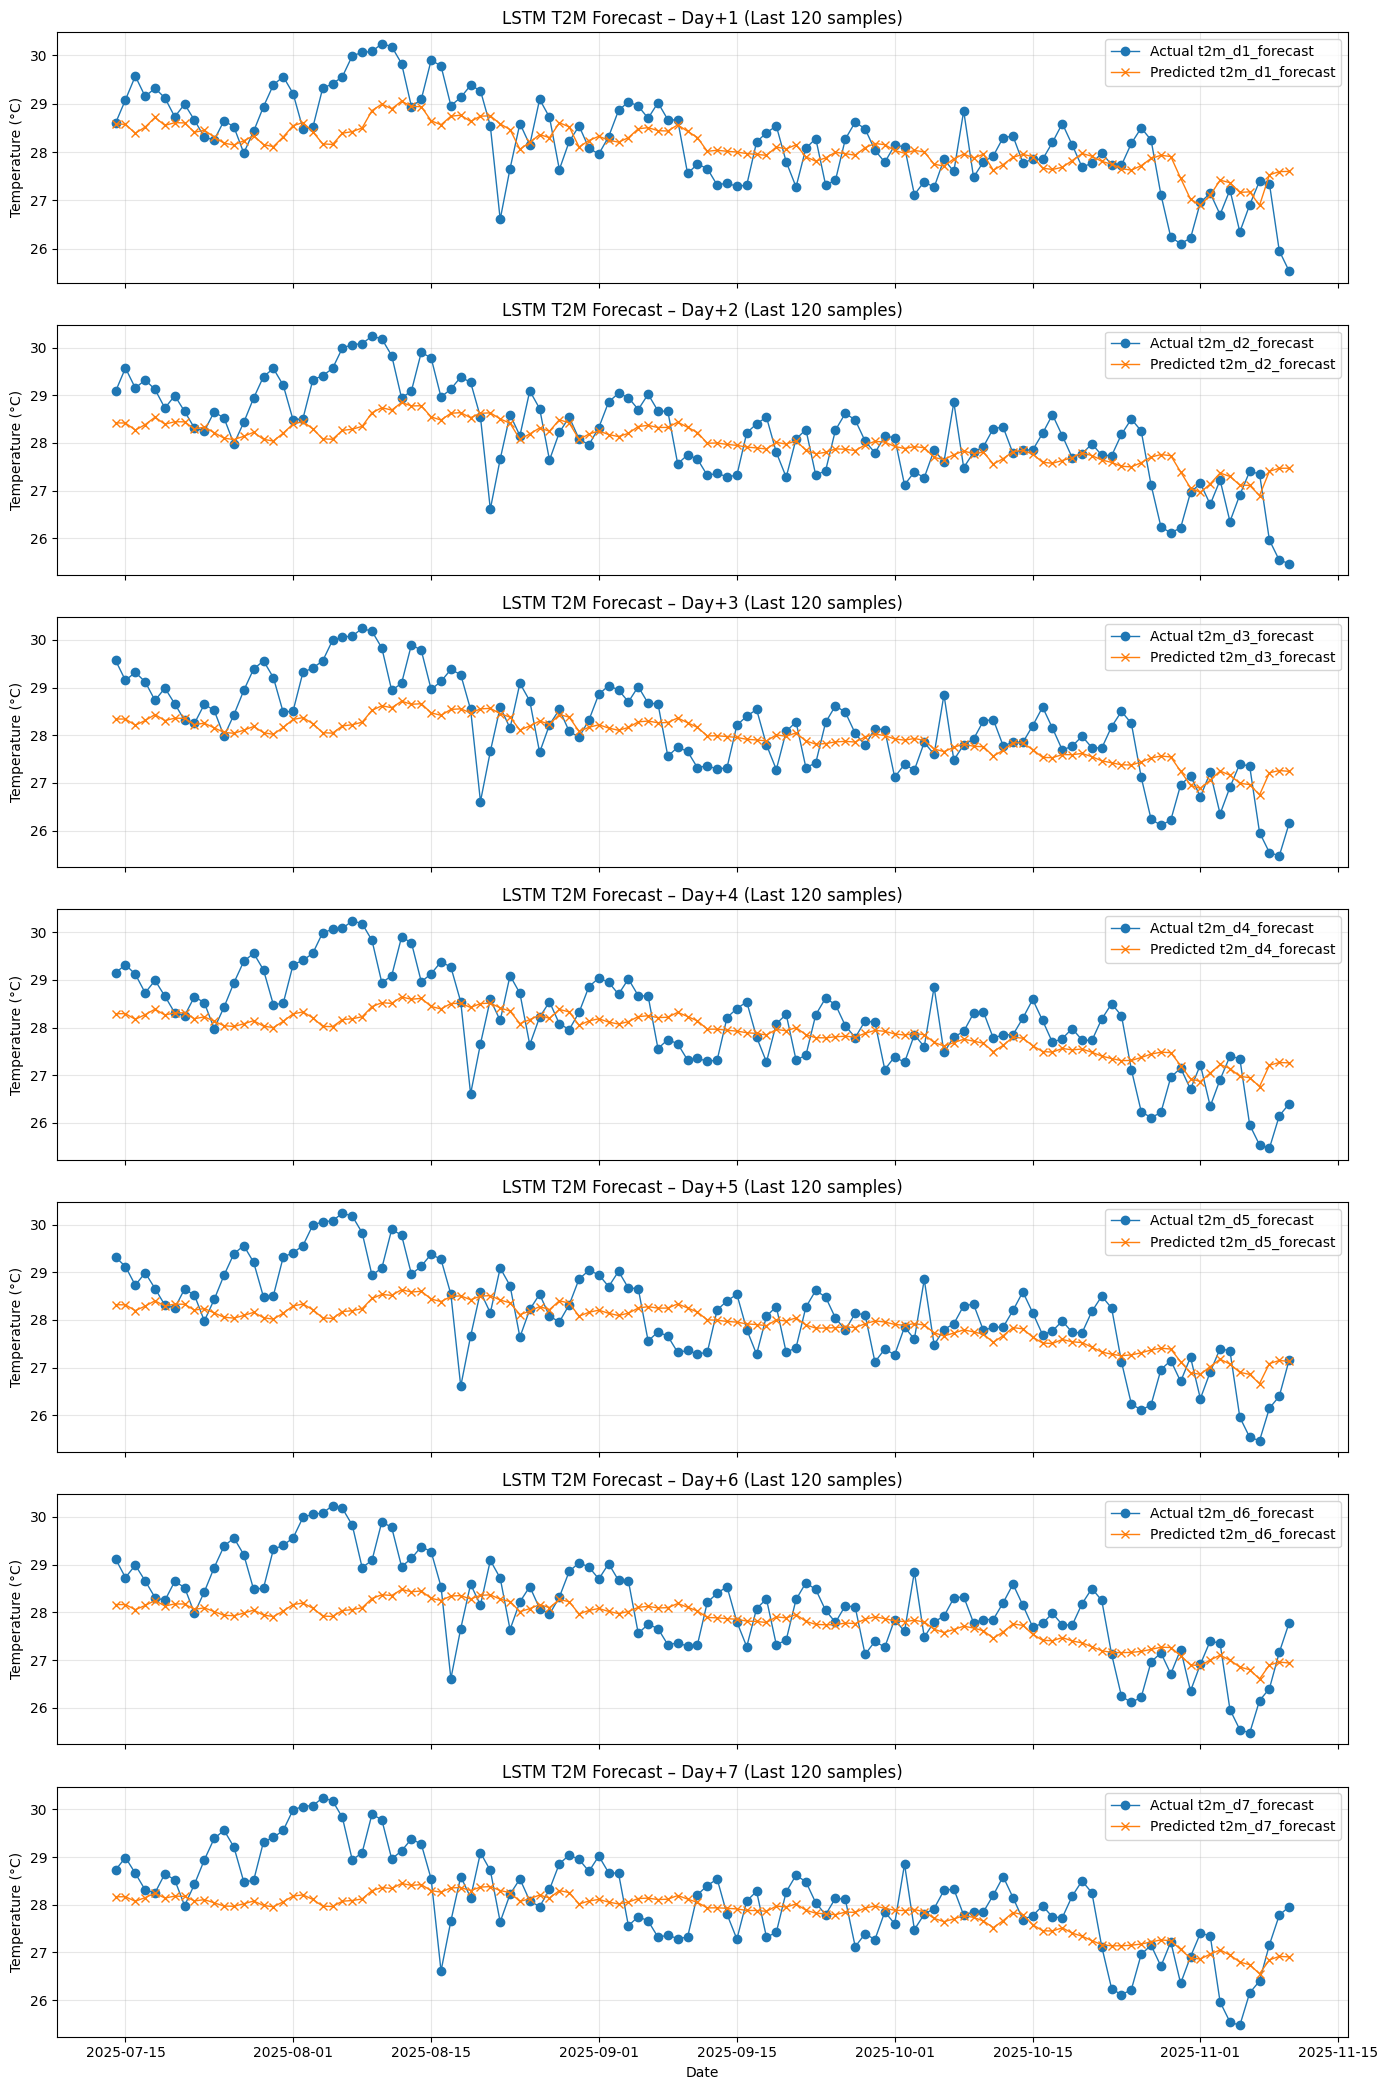

In [48]:
# จำนวนจุดที่อยาก zoom ดู
N = 120  # เช่น 4 เดือนสุดท้าย
days = [f"Day+{i+1}" for i in range(H)]
fig, axs = plt.subplots(H, 1, figsize=(14, 3*H), sharex=True)
for h in range(H):
    dates_zoom = dates_test[-N:]
    y_test_zoom = Y_test_inv[-N:, h]
    y_pred_zoom = Y_pred_inv[-N:, h]
    axs[h].plot(dates_zoom, y_test_zoom, label=f"Actual {targets[h]}", marker="o", linewidth=1)
    axs[h].plot(dates_zoom, y_pred_zoom, label=f"Predicted {targets[h]}", marker="x", linewidth=1)
    axs[h].set_title(f"LSTM T2M Forecast – {days[h]} (Last {N} samples)")
    axs[h].set_ylabel("Temperature (°C)")
    axs[h].legend()
    axs[h].grid(True, alpha=0.3)
plt.xlabel("Date")
plt.tight_layout()
plt.show()